# NPS Analysis

### NPS Case

One month after a user has joined the company, we send them an "NPS survey",asking them how likely they are, on a scale from 0 to 10, to recommend our company to a colleague. Please find attached the list of survey responses we received, as well as additional information about the respondents

### Set libraries

In [100]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from pandasql import sqldf

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

### Import Data

In [19]:
nps = pd.read_csv("nps_survey.csv")

### SQL Code

The query is executed in two steps:
1. CTE is used to add created month dimension for grouping and promoter and detractor flag are assigned to each user.
2. NPS is calculated for All, Admin and Regular users and group by created month to analyze the last 18 months trend.

In [33]:
query = """
WITH calc AS (
SELECT nps.*
, STRFTIME('%Y-%m',nps.created_at) AS created_month
, CASE WHEN score >= 9 THEN 1 ELSE 0 END AS promoter
, CASE WHEN score <= 6 THEN 1 ELSE 0 END AS detractor
FROM nps
)

SELECT created_month
, 100.00 * (SUM(promoter) - SUM(detractor)) / COUNT(*) AS ALL_NPS
,  100.00 * (SUM(CASE WHEN is_admin = 1 THEN promoter ELSE 0 END) - SUM(CASE WHEN is_admin = 1 THEN detractor ELSE 0 END)) /
    SUM(CASE WHEN is_admin = 1 THEN 1 ELSE 0 END) AS ADMIN_NPS
,  100.00 * (SUM(CASE WHEN is_admin = 0 THEN promoter ELSE 0 END) - SUM(CASE WHEN is_admin = 0 THEN detractor ELSE 0 END)) /
    SUM(CASE WHEN is_admin = 0 THEN 1 ELSE 0 END) AS REGULAR_NPS
FROM calc
GROUP BY created_month

"""
trend = sqldf(query)

### NPS Trend Analysis

#### Trend chart code

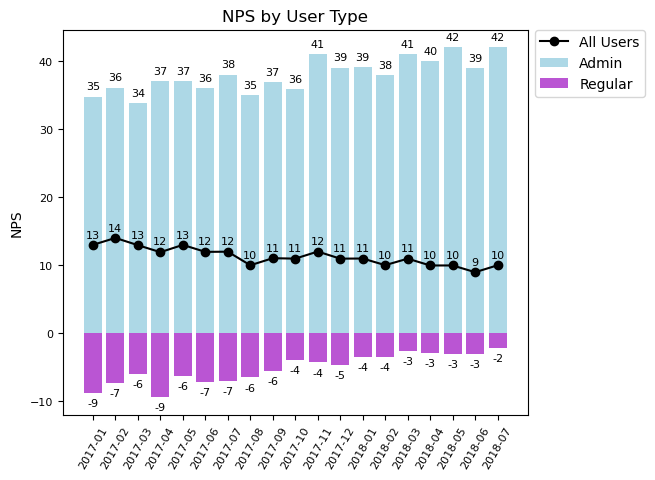

In [35]:
# Create figure and axes
fig, ax1 = plt.subplots(figsize=(6, 5))

# Plot bars on the primary y-axis
ax1.bar( trend['created_month'],trend['ADMIN_NPS'], color='lightblue', label='Admin')
ax1.bar( trend['created_month'],trend['REGULAR_NPS'], color='mediumorchid', label='Regular')

# Function to place labels at the center of each bar
def add_labels_bars(x, y):
    for i in range(len(x)):
        if y[i] >= 0:
            plt.text(i, y[i]+1, round(y[i]), ha='center', fontsize=8)  # Placing text at the top of the bar
        else:
            plt.text(i, y[i]-2, round(y[i]), ha='center', fontsize=8)  # Placing text at the bottom of the bar 

def add_labels_line(x, y):
    for i in range(len(x)):
        plt.text(i, round(y[i])+ 1, round(y[i]), ha='center', fontsize=8)  # Placing text at the top of the line

add_labels_bars(trend['created_month'],trend['ADMIN_NPS'])
add_labels_bars(trend['created_month'],trend['REGULAR_NPS'])
add_labels_line(trend['created_month'],trend['ALL_NPS'])

# Plot line
ax1.plot(trend['created_month'], trend['ALL_NPS'], color='black', marker='o', label='All Users')
ax1.set_ylabel('NPS', color='black', fontsize=10)
ax1.tick_params(axis='y', labelcolor='black', labelsize=8)

# Add title and legend
plt.title('NPS by User Type')
fig.legend(loc="upper left", bbox_to_anchor=(0.9, 0.894)) # Adjust legend position

#x-axis value orientation
ax1.tick_params(axis='x', labelrotation=60, labelsize=8) 

# Show plot
plt.show()

Admin and Regular users' NPS has individually increased during the last 18 month but the overall NPS has decreased in the same period of time.

### Deep Dive

#### Expanding NPS data

In [47]:
query = """
SELECT nps.*
, STRFTIME('%Y-%m',nps.created_at) AS created_month
, CAST(JULIANDAY(surveyed_at) - JULIANDAY(created_at) AS INTEGER) AS tenure
, CASE WHEN score >= 9 THEN 1 ELSE 0 END AS promoter
, CASE WHEN score <= 6 THEN 1 ELSE 0 END AS detractor
, CASE WHEN score >= 9 THEN 'promoter'
    WHEN score <= 6 THEN 'detractor'
    ELSE 'passive' END AS category
FROM nps
"""

data = sqldf(query)

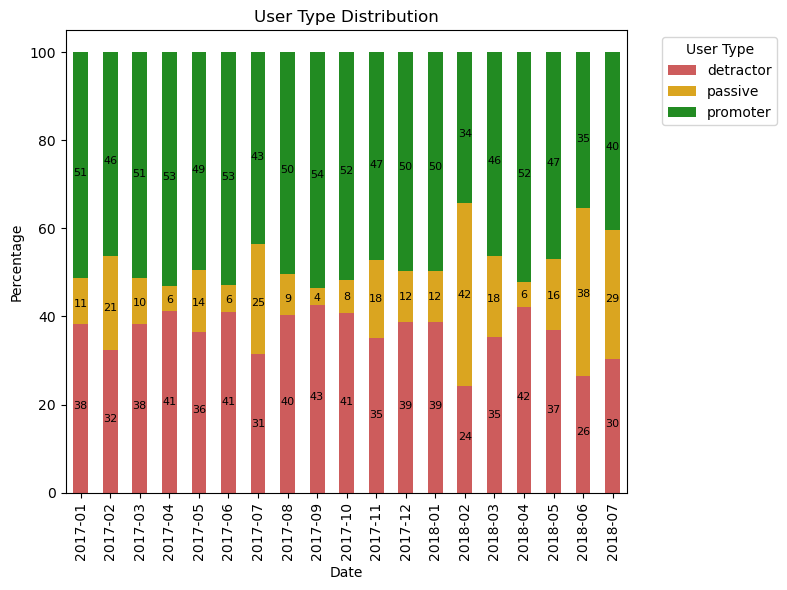

In [102]:
pivot_df = data.pivot_table(index='created_month', columns='category', aggfunc='size', fill_value=0)
pivot_df_percentage = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100
pivot_df_percentage.plot.bar(stacked=True, color = ['indianred','goldenrod','forestgreen'], figsize=(8, 6))

def add_labels_bars(x, y):
    for i in range(len(x)):
        if y.name == 'detractor':
            plt.text(i, round(y[i])//2, round(y[i]), ha='center', fontsize=8)  # Placing text at half of the bar
        if y.name == 'passive':
            plt.text(i, round(y[i])//2 + pivot_df_percentage['detractor'][[i]] - 1, round(y[i]), ha='center', fontsize=8)
        if y.name == 'promoter':
            plt.text(i, round(y[i])//2 + pivot_df_percentage['detractor'][[i]]  + pivot_df_percentage['passive'][[i]] - 2, round(y[i]), ha='center', fontsize=8)

add_labels_bars(pivot_df_percentage.index,pivot_df_percentage['detractor'])
add_labels_bars(pivot_df_percentage.index,pivot_df_percentage['passive'])
add_labels_bars(pivot_df_percentage.index,pivot_df_percentage['promoter'])

plt.title('User Type Distribution')
plt.ylabel('Percentage')
plt.xlabel('Date')
plt.legend(title='User Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

The chart above shows the user type distribution over time. The trend show tha promoters have a downward trend. During the last six month there had been months with a significant proportion of passive users what is not seen on the initial months.

### User distribution on each segment

In [61]:
 admin = data[data['is_admin'] == 1]
 regular = data[data['is_admin'] == 0]

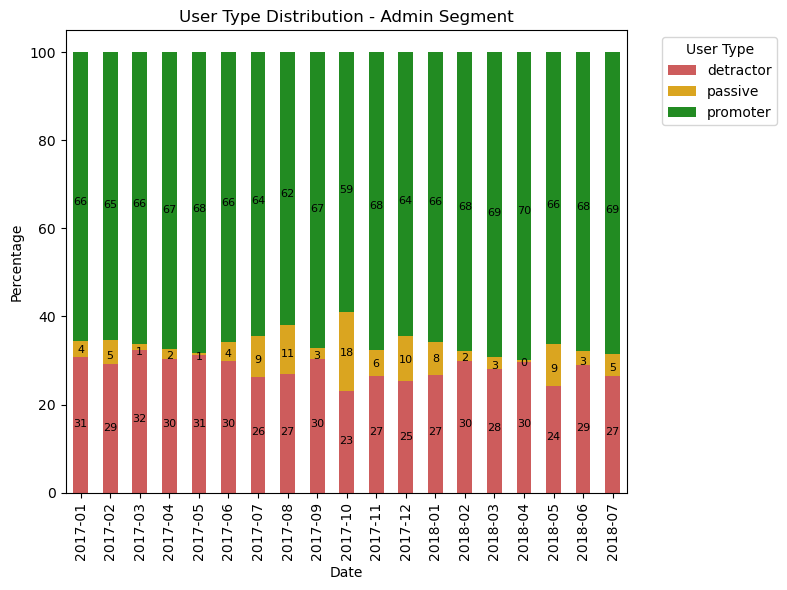

In [104]:
pivot_df = admin.pivot_table(index='created_month', columns='category', aggfunc='size', fill_value=0)
pivot_df_percentage = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100
pivot_df_percentage.plot.bar(stacked=True, color = ['indianred','goldenrod','forestgreen'], figsize=(8, 6))

def add_labels_bars(x, y):
    for i in range(len(x)):
        if y.name == 'detractor':
            plt.text(i, round(y[i])//2, round(y[i]), ha='center', fontsize=8)  # Placing text at half of the bar
        if y.name == 'passive':
            plt.text(i, round(y[i])//2 + pivot_df_percentage['detractor'][[i]] - 1, round(y[i]), ha='center', fontsize=8)
        if y.name == 'promoter':
            plt.text(i, round(y[i])//2 + pivot_df_percentage['detractor'][[i]]  + pivot_df_percentage['passive'][[i]] - 2, round(y[i]), ha='center', fontsize=8)

add_labels_bars(pivot_df_percentage.index,pivot_df_percentage['detractor'])
add_labels_bars(pivot_df_percentage.index,pivot_df_percentage['passive'])
add_labels_bars(pivot_df_percentage.index,pivot_df_percentage['promoter'])

plt.title('User Type Distribution - Admin Segment')
plt.ylabel('Percentage')
plt.xlabel('Date')
plt.legend(title='User Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

The number of passive users on the admin segment is steady. The promoter has grown over time.

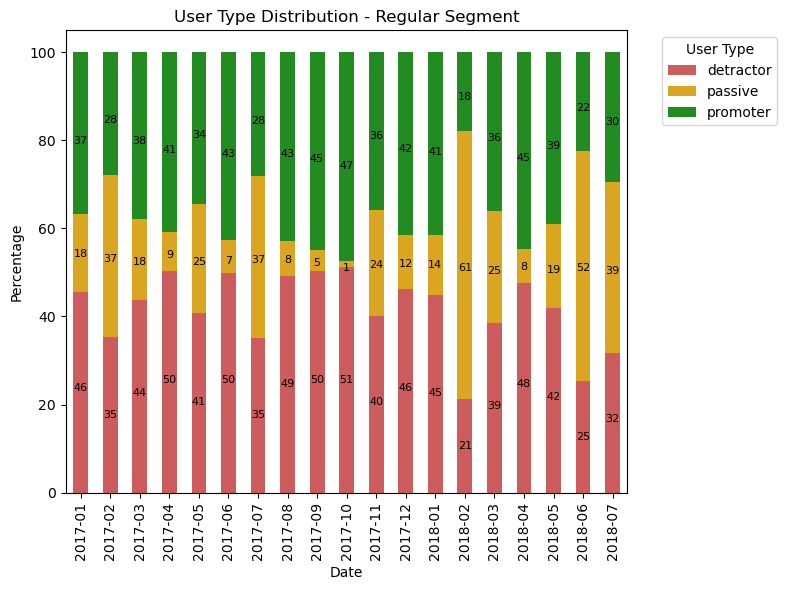

In [106]:
pivot_df = regular.pivot_table(index='created_month', columns='category', aggfunc='size', fill_value=0)
pivot_df_percentage = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100
pivot_df_percentage.plot.bar(stacked=True, color = ['indianred','goldenrod','forestgreen'], figsize=(8, 6))

def add_labels_bars(x, y):
    for i in range(len(x)):
        if y.name == 'detractor':
            plt.text(i, round(y[i])//2, round(y[i]), ha='center', fontsize=8)  # Placing text at half of the bar
        if y.name == 'passive':
            plt.text(i, round(y[i])//2 + pivot_df_percentage['detractor'][[i]] - 1, round(y[i]), ha='center', fontsize=8)
        if y.name == 'promoter':
            plt.text(i, round(y[i])//2 + pivot_df_percentage['detractor'][[i]]  + pivot_df_percentage['passive'][[i]] - 2, round(y[i]), ha='center', fontsize=8)

add_labels_bars(pivot_df_percentage.index,pivot_df_percentage['detractor'])
add_labels_bars(pivot_df_percentage.index,pivot_df_percentage['passive'])
add_labels_bars(pivot_df_percentage.index,pivot_df_percentage['promoter'])

plt.title('User Type Distribution - Regular Segment')
plt.ylabel('Percentage')
plt.xlabel('Date')
plt.legend(title='User Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Regular segment has had a significant increase on passive users and a similar decrease between promoter and detractor

### Admin / Regular Segment users trend

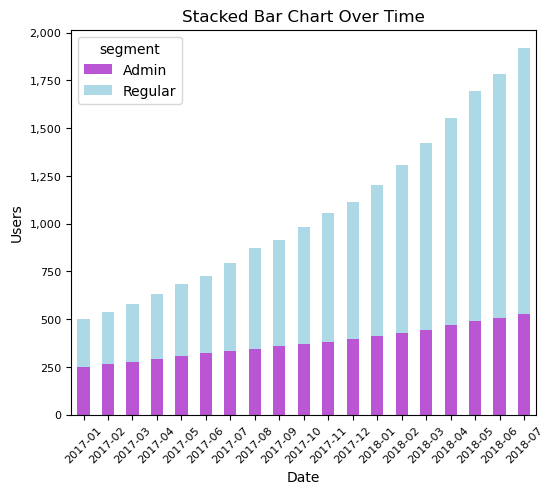

In [108]:
data['segment'] = 'Regular'
data['segment'][data['is_admin']==1] = 'Admin'
df_grouped = data.groupby(['created_month', 'segment'])['id'].size().unstack()
df_grouped.plot(kind='bar', stacked=True, color = ['mediumorchid','lightblue'], figsize=(6, 5), title='Stacked Bar Chart Over Time')
plt.xlabel('Date')
plt.ylabel('Users')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
plt.tick_params(axis='y', labelcolor='black', labelsize=8)
plt.tick_params(axis='x', labelcolor='black', labelsize=8)
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.show()

Regular users have had an explosive increase in time. Admin users have also increased but not in the same rate.

### Conclusion

The explosive growth of regular segment has had a significant impact in the NPS. Despite both Admin and Regular NPS has improved, Regular NPS has a major weight on the NPS what pulls the NPS down.
Additionally there is an increase on passive users driven, specially on the regular segment that also is having an influence on bringing the NPS down.
The big differences in the NPS between regular and admin users could drive focused actions to improve product perception specially on the regular users.